In [85]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [87]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

from keras.datasets import mnist

from keras.utils import np_utils

from keras import backend as K

In [88]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [89]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

In [90]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [91]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [92]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [93]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [94]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [95]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 100)          78500       input_6[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 2)            202         dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            202         dense_20[0][0]                   
__________________________________________________________________________________________________
lambda_3 (

In [96]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [97]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [98]:
VAE.fit(x_train, x_train, batch_size=64, epochs=50)

Epoch 1/50
60000/60000 [==============================] - 7s 113us/step - loss: 206.5398
Epoch 2/50
60000/60000 [==============================] - 6s 96us/step - loss: 182.4769
Epoch 3/50
60000/60000 [==============================] - 6s 101us/step - loss: 180.4271
Epoch 4/50
60000/60000 [==============================] - 7s 109us/step - loss: 179.4346
Epoch 5/50
60000/60000 [==============================] - 6s 107us/step - loss: 178.3720
Epoch 6/50
60000/60000 [==============================] - 7s 112us/step - loss: 176.5617
Epoch 7/50
60000/60000 [==============================] - 6s 105us/step - loss: 174.2436
Epoch 8/50
60000/60000 [==============================] - 7s 118us/step - loss: 171.6767
Epoch 9/50
60000/60000 [==============================] - 6s 98us/step - loss: 169.6023
Epoch 10/50
60000/60000 [==============================] - 6s 95us/step - loss: 167.8450
Epoch 11/50
60000/60000 [==============================] - 6s 99us/step - loss: 166.5994
Epoch 12/50
60000/60000

In [99]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [100]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [101]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_24 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [102]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 52707 圖的 latent 表示為 [[-1.0549632  1.7707577]]


In [103]:
indices = np.random.randint(x_test.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

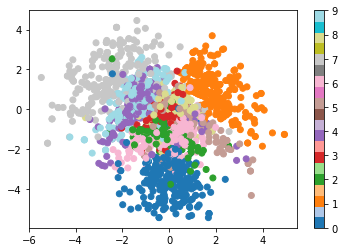

In [104]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [105]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [106]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [107]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

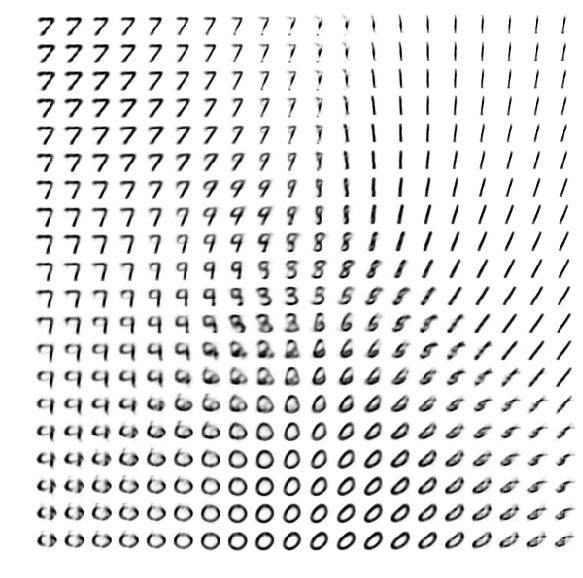

In [108]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [109]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [110]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [111]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.01,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>